[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YuichiKZ/pytorch_gan/blob/main/Section5_1_DCGAN_MNIST_pytorch.ipynb)

## DCGANのノートブック
- このノートブックではPyTorchによるDCGANネットワークの実装と学習を行います。

#学習目標
- 画像を生成するGenerator(生成器)の転置畳み込みNNの構造を理解する
- 画像を識別するDiscriminator(識別器)の畳み込みNNの構造を理解する
- DCGANのネットワークを実装できるようにする
- GANの損失関数とニューラルネットワークの学習の流れを理解する


# GPU確認

In [1]:
!nvidia-smi

Mon May  9 12:16:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PyTorch インポート & バージョン確認

In [2]:
import torch
import torchvision
# バージョンの確認
print(torch.__version__) 
print(torchvision.__version__) 

1.11.0+cu113
0.12.0+cu113


# DCGAN実装

## パッケージインポート

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchsummary

## パラメータ設定

In [5]:
batch_size=50
z_dim = 100 #ノイズ次元
g_dim = 128 
d_dim = 128 
num_epochs = 10 #エポック数
lr = 0.0002 #学習率
beta1 = 0.5
out_dir = './result_2-DCGAN'
loss_display_interval = 600

# 保存先ディレクトリを作成
try:
    os.makedirs(out_dir, exist_ok=True)
except Exception as error: 
    print(error)

# 乱数のシード（種）を固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

##データセット定義

- `transforms.Compose(transforms)`
<br>
複数の Transform を連続して行う Transform を作成
- `transforms.ToTensor()`
<br>
PIL Imageまたはnumpy ndarrayをTorch Tensorに変換
- `transforms.Normalize((mean,...),(std,...))`
<br>
各チャンネルに関して標準化を行う<br>
$output[channel] = (input[channel]-mean[channel])/std[channel]$
<br>
i.e. <br>
MNISTの場合<br>
チャンネル数: 1(白黒画像)<br>
分布: [0,1]<br>
より
$std=0.5, mean=0.5$とすると
分布は[-1,1]となる。

In [7]:
# MNISTの訓練データセットを読み込む
# transforms.ToTensor()-> Torch Tensorに変換
# transforms.Normalize((mean,),(std)) -> テンソルの値を平均0
dataset = dset.MNIST(root='./mnist_data', download=True, train=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)) ]))

In [8]:
# 画像配列の形状確認
dataset[0][0].shape

torch.Size([1, 28, 28])

In [9]:
# 訓練データをセットしたDataLoader作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# 学習に使用するデバイスを指定。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


##ネットワークの定義

### Generatorクラス

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, g_dim=128, nch=1):
        """
        z_dim: 入力ベクトルzの次元
        g_dim: 最終層の入力チャネル数
        nch: 出力画像のチャネル数
        """
        super(Generator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layer0 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = z_dim,
                out_channels = g_dim * 4,
                kernel_size = 3,
                stride = 1,
                padding = 0
            ),     # 転置畳み込み
            nn.BatchNorm2d(g_dim * 4),                      # バッチノーマライゼーション
            nn.ReLU()                                       # ReLU
        )  # (B, z_dim, 1, 1) -> (B, g_dim*4, 3, 3)

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = g_dim * 4,
                               out_channels = g_dim * 2, 
                               kernel_size = 3, 
                               stride = 2, 
                               padding = 0
            ),     # 転置畳み込み
            nn.BatchNorm2d(g_dim * 2),
            nn.ReLU()
        )  # (B, g_dim*4, 3, 3) -> (B, g_dim*2, 7, 7)

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = g_dim * 2, 
                out_channels = g_dim, 
                kernel_size = 4, 
                stride = 2, 
                padding = 1
            ),
            nn.BatchNorm2d(g_dim),
            nn.ReLU()
        )  # (B, g_dim*2, 7, 7) -> (B, g_dim, 14, 14)

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = g_dim, 
                out_channels = nch, 
                kernel_size = 4, 
                stride = 2, 
                padding = 1
            ),
            nn.Tanh()
        )  # (B, g_dim, 14, 14) -> (B, nch, 28, 28)

        self.layers = [self.layer0,
                       self.layer1,
                       self.layer2,
                       self.layer3]

    def forward(self, z):
        """
        順方向の演算
        z: 入力ノイズ
        return z: 生成画像
        """
        for layer in self.layers:  # self.layersの各層で演算を行う
            z = layer(z)
        return z

### Discriminatorクラス

In [11]:
class Discriminator(nn.Module):
    """
    識別器Dのクラス
    """
    def __init__(self, nch=1, d_dim=128):
        """
        :param nch: 入力画像のチャネル数
        :param d_dim: 先頭層の出力チャネル数
        """
        super(Discriminator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layer0 = nn.Sequential(
                nn.Conv2d(nch, d_dim, 4, 2, 1),     # 畳み込み
                nn.LeakyReLU(negative_slope=0.2)    # leaky ReLU関数
            )  # (B, nch, 28, 28) -> (B, d_dim, 14, 14)
        self.layer1 = nn.Sequential(
                nn.Conv2d(d_dim, d_dim * 2, 4, 2, 1),
                nn.BatchNorm2d(d_dim * 2),
                nn.LeakyReLU(negative_slope=0.2)
            )
        self.layer2 = nn.Sequential(
                nn.Conv2d(d_dim * 2, d_dim * 4, 3, 2, 0),
                nn.BatchNorm2d(d_dim * 4),
                nn.LeakyReLU(negative_slope=0.2)
            )  # (B, d_dim*2, 7, 7) -> (B, d_dim*4, 3, 3)
        self.layer3 = nn.Sequential(
                nn.Conv2d(d_dim * 4, 1, 3, 1, 0),
                nn.Sigmoid()    # Sigmoid関数
            )    # (B, d_dim*4, 3, 3) -> (B, 1, 1, 1)
        self.layers =[self.layer0,
                      self.layer1,
                      self.layer2,
                      self.layer3]

    def forward(self, x):
        """
        順方向演算
        x: 本物画像または生成画像
        return: 識別信号
        """
        for layer in self.layers:  # self.layersの各層で演算を行う
            x = layer(x)
        return x.squeeze()     # Tensorの形状を(B,1,1,1)->(B)に変更して戻り値とする

### 重み初期化関数

In [12]:
def weights_init(m):
    """
    ニューラルネットワークの重みを初期化する。作成したインスタンスに対しapplyメソッドで適用する
    :param m: ニューラルネットワークを構成する層
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:            # 畳み込み層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:     # バッチノーマライゼーションの場合
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### 生成器Gのインスタンス生成と重み初期化

In [13]:
# 生成器G　インスタンス化, GPU上に転送
G = Generator(z_dim=z_dim, g_dim=g_dim).to(device)
G.apply(weights_init)    # weights_init関数で初期化

Generator(
  (layer0): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)

### 生成器のTensor形状確認

In [14]:
# 生成器GのTensor形状
# torchsummary.summary(network, 入力テンソル形状)
# 入力: 100次元のノイズベクトル
torchsummary.summary(G, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 3, 3]         461,312
       BatchNorm2d-2            [-1, 512, 3, 3]           1,024
              ReLU-3            [-1, 512, 3, 3]               0
   ConvTranspose2d-4            [-1, 256, 7, 7]       1,179,904
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
   ConvTranspose2d-7          [-1, 128, 14, 14]         524,416
       BatchNorm2d-8          [-1, 128, 14, 14]             256
              ReLU-9          [-1, 128, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           2,049
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 2,169,473
Trainable params: 2,169,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

### 識別器Dのインスタンス化と重み初期化

In [15]:
# 識別器D　インスタンス化, GPU上に転送
D = Discriminator(d_dim=d_dim).to(device)
D.apply(weights_init)

Discriminator(
  (layer0): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer1): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequential(
    (0): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): Sigmoid()
  )
)

### 識別器のTensor形状確認

In [16]:
# 識別器DのTensor形状
# torchsummary.summary(network, 入力テンソル形状)
# 入力: 1channel*28px*28pxの画像
torchsummary.summary(D, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
         LeakyReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]         524,544
       BatchNorm2d-4            [-1, 256, 7, 7]             512
         LeakyReLU-5            [-1, 256, 7, 7]               0
            Conv2d-6            [-1, 512, 3, 3]       1,180,160
       BatchNorm2d-7            [-1, 512, 3, 3]           1,024
         LeakyReLU-8            [-1, 512, 3, 3]               0
            Conv2d-9              [-1, 1, 1, 1]           4,609
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 1,713,025
Trainable params: 1,713,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.78
Params size (MB): 6.53
Estimat

## 学習の実行

In [17]:
criterion = nn.BCELoss()    # バイナリークロスエントロピー

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)  

# オプティマイザの用意
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [18]:
G_losses = []
D_losses = []

#最初の画像の保存
fake_image = G(fixed_noise)
vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(out_dir, 0),
                      normalize=True, nrow=10)

# 学習のループ
for epoch in range(num_epochs):
    for n, images in enumerate(dataloader):
        real_image = images[0].to(device)     # 本物画像, GPU上に転送
        sample_size = real_image.size(0)    # 画像枚数
        
        # 標準正規分布(平均0,分散1)からノイズを生成, GPU上に転送
        noise = torch.randn(sample_size, z_dim, 1, 1, device=device)
        # 本物画像に対する正解ラベル:1 , GPU上に転送
        real_target = torch.full((sample_size,), 1., device=device)
        # 生成画像に対する正解ラベル:0 , GPU上に転送
        fake_target = torch.full((sample_size,), 0., device=device)
        
        """
        識別器Dの更新
        """
        D.zero_grad()    # 勾配初期化

        ########################
        # 本物画像に対する損失計算
        ########################
        output = D(real_image) # 識別器Dで本物画像に対する識別信号を出力
        lossD_real = criterion(output, real_target) # 本物画像に対する識別信号の損失値

        ########################
        # 偽物画像に対する損失計算
        ########################
        fake_image = G(noise) # 生成器Gでノイズから生成画像を生成

        output = D(fake_image.detach())  # 識別器Dで本物画像に対する識別信号を出力
        lossD_fake = criterion(output, fake_target)  # 生成画像に対する識別信号の損失値

        ########################
        # 損失計算し,誤差逆伝播
        ########################
        lossD = lossD_real + lossD_fake    # 識別器Dの全体の損失
        lossD.backward()    # 誤差逆伝播
        optimizerD.step()   # Dのパラメーターを更新

        """
        生成器Gの更新
        """
        G.zero_grad()    # 勾配の初期化

        output = D(fake_image)   # 更新した識別器Dで改めて生成画像に対する識別信号を出力
        lossG = criterion(output, real_target)   # 生成器Gの損失値。Dに生成画像を本物画像と誤認させたいため目標値は「1」
        lossG.backward()     # 誤差逆伝播

        optimizerG.step()   # Gのパラメータを更新
        
        """
        DとGのロス表示
        """
        if n % loss_display_interval == 0: 
            print('epoch:[{}/{}],num_images:[{}/{}] Loss_D: {:.3f} Loss_G: {:.3f}'
                  .format(epoch + 1, num_epochs,
                          n + 1, len(dataloader),
                          lossD.item(), lossG.item()))


        if epoch == 0 and n == 0:     # 初回に本物画像を保存する
            vutils.save_image(real_image, '{}/real_samples.png'.format(out_dir),
                              normalize=True, nrow=10)

        # ログ出力用データの保存
        D_losses.append(lossD.item())
        G_losses.append(lossG.item())

    """
    確認用画像の生成
    """
    fake_image = G(fixed_noise)  # 1エポック終了ごとに確認用の生成画像を生成する
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(out_dir, epoch + 1),
                      normalize=True, nrow=10)

    """
    モデルの保存
    """
    if (epoch + 1) % 5 == 0:   # 5エポックごとにモデルを保存
        torch.save(G.state_dict(), '{}/G_epoch_{}.pth'.format(out_dir, epoch + 1))
        torch.save(D.state_dict(), '{}/D_epoch_{}.pth'.format(out_dir, epoch + 1))

epoch:[1/10],num_images:[1/1200] Loss_D: 1.493 Loss_G: 2.977
epoch:[1/10],num_images:[601/1200] Loss_D: 0.399 Loss_G: 4.434
epoch:[2/10],num_images:[1/1200] Loss_D: 0.885 Loss_G: 1.881
epoch:[2/10],num_images:[601/1200] Loss_D: 0.803 Loss_G: 1.551
epoch:[3/10],num_images:[1/1200] Loss_D: 1.119 Loss_G: 1.413
epoch:[3/10],num_images:[601/1200] Loss_D: 0.589 Loss_G: 1.962
epoch:[4/10],num_images:[1/1200] Loss_D: 0.351 Loss_G: 2.604
epoch:[4/10],num_images:[601/1200] Loss_D: 0.182 Loss_G: 3.161
epoch:[5/10],num_images:[1/1200] Loss_D: 0.308 Loss_G: 2.930
epoch:[5/10],num_images:[601/1200] Loss_D: 0.410 Loss_G: 3.230
epoch:[6/10],num_images:[1/1200] Loss_D: 0.788 Loss_G: 4.790
epoch:[6/10],num_images:[601/1200] Loss_D: 0.677 Loss_G: 2.663
epoch:[7/10],num_images:[1/1200] Loss_D: 0.245 Loss_G: 3.491
epoch:[7/10],num_images:[601/1200] Loss_D: 0.428 Loss_G: 2.464
epoch:[8/10],num_images:[1/1200] Loss_D: 0.205 Loss_G: 4.788
epoch:[8/10],num_images:[601/1200] Loss_D: 0.695 Loss_G: 1.327
epoch:[9

### 学習済みモデルの推論画像表示

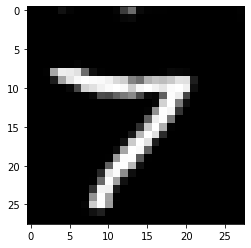

In [32]:
from PIL import Image
# 標準正規分布(平均0,分散1)からノイズを生成, GPU上に転送
noise = torch.randn(sample_size, z_dim, 1, 1, device=device)

fake_image = G(noise) # 生成器Gでノイズから生成画像を生成
fake_image = fake_image.to('cpu').detach() #Pytorch TensorをGPUからCPUに転送
fake_image = fake_image.numpy() #numpy arrayに変換
fake_image = fake_image.squeeze() #(B,C,H,W) -> (B,H,W)に変換

plt.imshow(fake_image[0],cmap='gray')

### 損失ロス

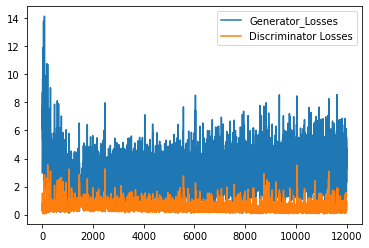

In [33]:
from matplotlib import pyplot as plt


plt.plot(G_losses, label='Generator_Losses')
plt.plot(D_losses, label='Discriminator Losses')
plt.legend()
plt.savefig('loss.png')

## 重みのロード & 推論

In [35]:
model_path = "/content/result_2-DCGAN/G_epoch_10.pth"

# 生成器G　ランダムベクトルから生成画像を作成する
G_infer = Generator(z_dim=z_dim, g_dim=g_dim).to(device)
G_infer.load_state_dict(torch.load(model_path))

# 生成器の画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

fake_image = G_infer(fixed_noise)  #確認用の画像を生成する
vutils.save_image(fake_image.detach(), '{}/Generator_sample.png'.format(out_dir),
                  normalize=True, nrow=10)

#画像の表示
gird_fake_images = vutils.make_grid(fake_image.detach(),normalize=True,nrow=10)
gird_fake_images = gird_fake_images.to('cpu').numpy()
gird_fake_images = np.transpose(gird_fake_images, [1,2,0]) #軸の入れ替え
plt.imshow(gird_fake_images)